# summarize the results of sensitivity analysis

Filtering: Keeping data where epsilon_s == 0.5
Scanning 12 directories...
Data Loaded. Count: 54


/var/folders/02/0ym8ylh51y3bbbn3ymbmr4j80000gq/T/ipykernel_32276/589875816.py:146: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.lineplot(
/Users/tomoyatakeda/Documents/Dev-SNAM2026-secondary-1/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


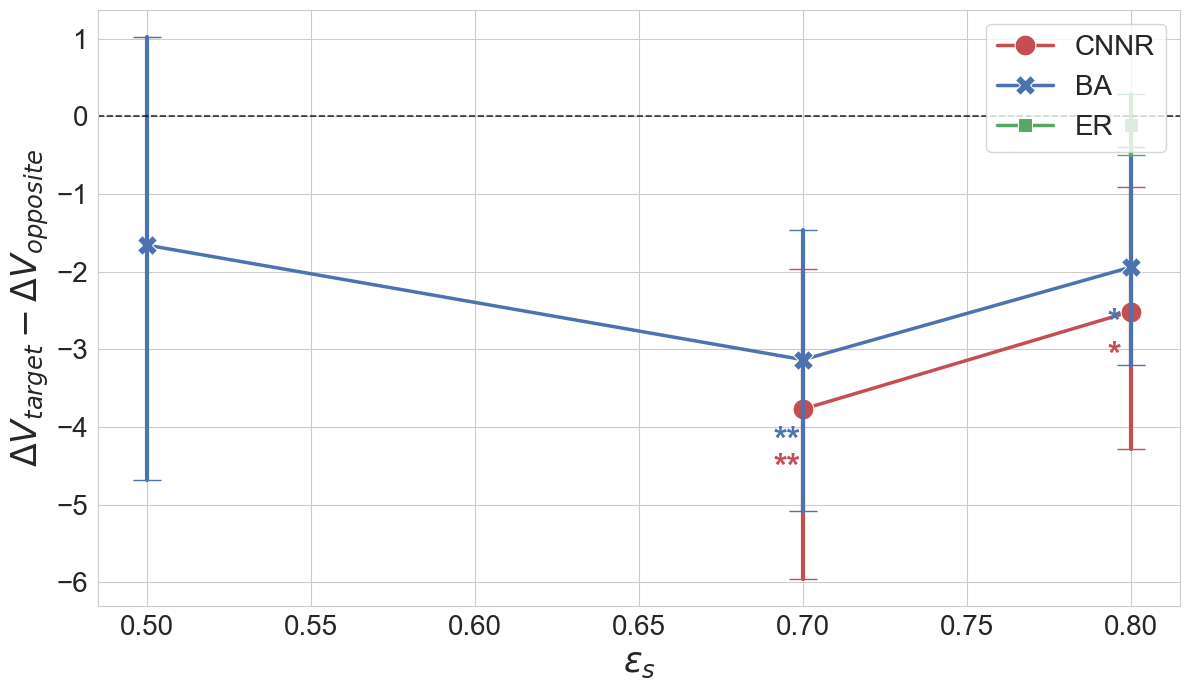

In [ ]:
import os
import glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

SUMMARY_ROOT = "./results/summary"

# you can choose the target of visualization ("mu" or "epsilon_s")
#TARGET_PARAM = "epsilon_s"  # 分析対象のパラメータ名
TARGET_PARAM = "mu"

RANGE_EARLY = (19000, 20000)
RANGE_LATE  = (39000, 40000)

CONDITIONS = {
    "mu":        {"fixed_key": "epsilon_s", "fixed_val": 0.5},
    "epsilon_s": {"fixed_key": "mu",        "fixed_val": 0.8}
}

def load_filtered_data(root_dir, target_param):
    data_records = []
    
    condition = CONDITIONS.get(target_param)
    if condition is None:
        print(f"Warning: No fixed condition defined for {target_param}. Loading all data.")
    else:
        print(f"Filtering: Keeping data where {condition['fixed_key']} == {condition['fixed_val']}")

    search_path = os.path.join(root_dir, "*", "*", "*")
    exp_dirs = glob.glob(search_path)
    
    print(f"Scanning {len(exp_dirs)} directories...")
    
    for d in exp_dirs:
        config_path = os.path.join(d, "config.yaml")
        csv_path = os.path.join(d, "post_timeseries.csv")
        
        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue
            
        try:
            with open(config_path, 'r') as f:
                config = yaml.safe_load(f)
            
            if condition:
                config_val = config.get(condition['fixed_key'])
                if config_val is None or not np.isclose(float(config_val), condition['fixed_val']):
                    continue

            path_parts = os.path.normpath(d).split(os.sep)
            topology = path_parts[-3] 
            if "topology" in config: topology = config["topology"]
            
            if target_param not in config: continue
            param_value = config[target_param]
            
            df_ts = pd.read_csv(csv_path)
            
            for seed, grp in df_ts.groupby("seed"):
                grp_early = grp[(grp['step'] >= RANGE_EARLY[0]) & (grp['step'] <= RANGE_EARLY[1])]
                grp_late  = grp[(grp['step'] >= RANGE_LATE[0])  & (grp['step'] <= RANGE_LATE[1])]
                
                if grp_early.empty or grp_late.empty: continue
                
                cols_target = ['target_extreme', 'target_mod']
                cols_opp    = ['opposite_extreme', 'opposite_mod']
                
                val_early_tar = grp_early[cols_target].sum(axis=1).mean()
                val_late_tar  = grp_late[cols_target].sum(axis=1).mean()
                
                val_early_opp = grp_early[cols_opp].sum(axis=1).mean()
                val_late_opp  = grp_late[cols_opp].sum(axis=1).mean()
                
                metric = (val_late_tar - val_early_tar) - (val_late_opp - val_early_opp)
                
                data_records.append({
                    "Topology": topology,
                    target_param: param_value,
                    "seed": seed,
                    "Backfire_Metric": metric
                })
                
        except Exception as e:
            continue

    return pd.DataFrame(data_records)

df_seeds = load_filtered_data(SUMMARY_ROOT, TARGET_PARAM)

if df_seeds.empty:
    print("No data found matching the criteria.")
else:
    print(f"Data Loaded. Count: {len(df_seeds)}")
    
    stats_results = []
    for (topo, param_val), group in df_seeds.groupby(["Topology", TARGET_PARAM]):
        t_stat, p_val = stats.ttest_1samp(group["Backfire_Metric"], 0, alternative='less')
        
        stats_results.append({
            "Topology": topo,
            TARGET_PARAM: param_val,
            "Mean_Metric": group["Backfire_Metric"].mean(),
            "p_value": p_val
        })
    df_stats = pd.DataFrame(stats_results)

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    
    palette = {"CNNR": "#c44e52", "BA": "#4c72b0", "ER": "#55a868"}

    ax = sns.lineplot(
        data=df_seeds,
        x=TARGET_PARAM,
        y="Backfire_Metric",
        hue="Topology",
        style="Topology",
        markers=True,
        dashes=False,
        linewidth=2.5,
        markersize=15,
        palette=palette,
        err_style="bars",        
        err_kws={'capsize': 10, 'elinewidth': 3},
        ci=95
    )

    fixed_x_offset = -0.005
    
    y_offset_factors = {"CNNR": 1.0, "BA": 1.8, "ER": 2.6}
    
    for _, row in df_stats.iterrows():
        p = row["p_value"]
        x = row[TARGET_PARAM]
        y = row["Mean_Metric"]
        topo = row["Topology"]
        
        if p < 0.05:
            marker = "**" if p < 0.01 else "*"
            
            base_dist = 0.5 if abs(y) < 1.0 else abs(y) * 0.15
            
            y_pos = y - (base_dist * y_offset_factors.get(topo, 1.0))
            
            x_pos = x + fixed_x_offset
            
            plt.text(x_pos, y_pos, marker, 
                     ha='center', va='top', 
                     fontsize=25, 
                     color=palette.get(topo, 'black'), 
                     fontweight='bold')

    plt.axhline(0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    
    fixed_cond = CONDITIONS.get(TARGET_PARAM)
    subtitle = f"(Fixed: {fixed_cond['fixed_key']}={fixed_cond['fixed_val']})" if fixed_cond else ""
    
    plt.xlabel(r"$\epsilon_s$", fontsize=25)
    #plt.xlabel(r"$\mu$", fontsize=25)
    plt.ylabel(r"$\Delta V_{target} - \Delta V_{opposite}$", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f"SA_results_{TARGET_PARAM}.png")
    plt.show()